In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import datetime as dt
import os
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from dtw import dtw
from sklearn.metrics import pairwise_distances
import pickle

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import datetime as dt
import os
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from dtw import dtw
from sklearn.metrics import pairwise_distances
import pickle
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
PRE_NAME = "onemin_ohlc_"
BEGIN_TIME = "09:00:00"
END_TIME = "11:00:00"
NUM_CLUSTER = 50
TIME_STEP = 10
def load_data(date_begin='20180612', date_end = '20200301', split_date_begin = '20200302', split_date_end = '20200915', train = True):
    X = []
    Y = []

    
    for sid in tqdm(os.listdir(os.path.join('dataset'))):
        for file in os.listdir(os.path.join('dataset', sid)):
            curday = file[12:20]
            if (train == True and curday <= date_end and curday >= date_begin) or (train == False and curday >= split_date_begin and curday <= split_date_end):
                df = pd.read_csv(os.path.join('dataset', sid, file))
                df = df
                mask = (df.loc[:, "time"] >= BEGIN_TIME) & (df.loc[:, "time"] <= END_TIME)
                front_df = df[mask].loc[:, "return"]
                front_df = front_df.take(np.arange(0, len(front_df), TIME_STEP))
                end_df = df[~mask].loc[:, "return"]
                if len(front_df) == (121 // TIME_STEP +1):
                    X.append(np.array(front_df))
                    Y.append(np.array(end_df))
    return np.array(X), np.array(Y)

def dtw_d(X, Y):
    manhattan_distance = lambda x, y: np.abs(x - y)
    d, cost_matrix, acc_cost_matrix, path = dtw(X, Y, dist=manhattan_distance)
    return d

def dtw_affinity(X):
    return pairwise_distances(X, metric=dtw_d)

def fastdtw_d(X, Y):
    return fastdtw(X, Y, dist=euclidean)[0]

def fastdtw_affinity(X):
    return pairwise_distances(X, metric=fastdtw_d)


X, Y = load_data()

100%|██████████| 13/13 [00:31<00:00,  2.46s/it]


In [12]:
X_test, Y_test = load_data(train=False)

100%|██████████| 13/13 [00:11<00:00,  1.10it/s]


In [13]:
print(X.shape)

(2492, 25)


In [14]:
print(X_test.shape)

(771, 25)


In [ ]:
t1 = time.time()
fastdtw_affinity(X)
t2 = time.time()
print("time:", t2-t1)
t1 = time.time()
dtw_affinity(X)
t2 = time.time()
print("time:", t2-t1)

In [6]:
t1 = time.time()
ac = AgglomerativeClustering(n_clusters = NUM_CLUSTER,
                             affinity = fastdtw_affinity,
                             linkage = 'complete')
X_label = ac.fit_predict(X)
t2 = time.time()
print(t2-t1)

435.90226221084595


In [7]:
t1 = time.time()
ac = AgglomerativeClustering(n_clusters = NUM_CLUSTER,
                             affinity = dtw_affinity,
                             linkage = 'complete')
X_label = ac.fit_predict(X)
t2 = time.time()
print(t2-t1)

189.58023047447205


In [15]:
t1 = time.time()
ac = AgglomerativeClustering(n_clusters = NUM_CLUSTER,
                             linkage = 'complete')
X_label = ac.fit_predict(X)
t2 = time.time()
print(t2-t1)

0.16655254364013672


In [16]:
X_label

array([42, 42, 14, ...,  5, 19,  5], dtype=int64)

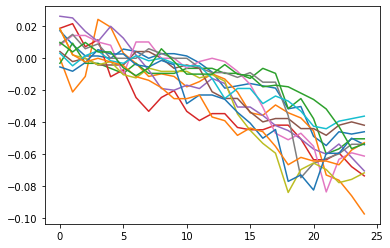

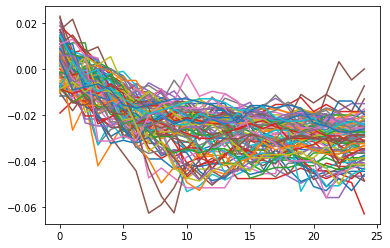

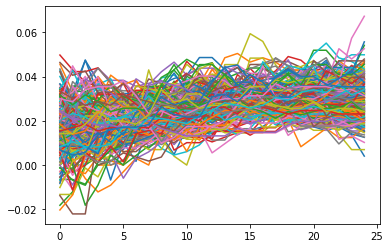

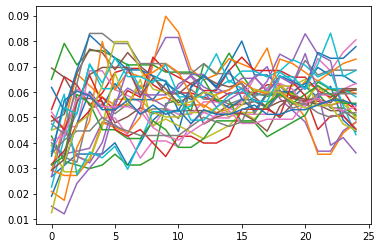

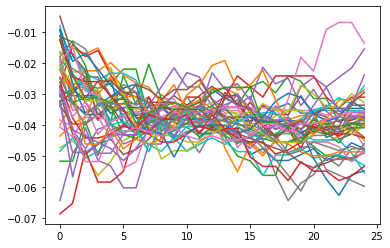

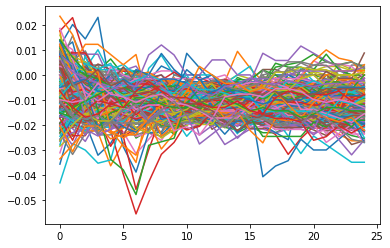

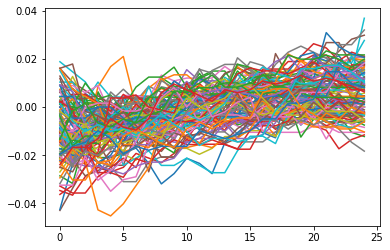

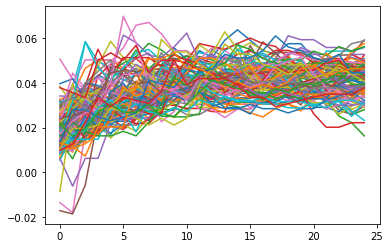

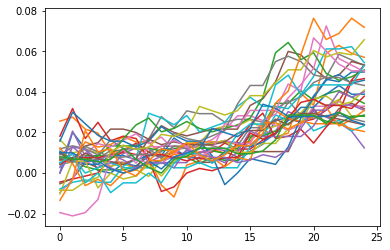

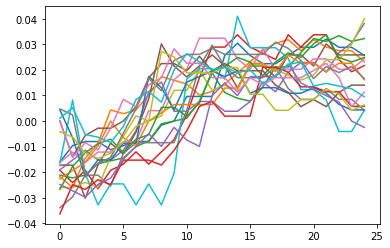

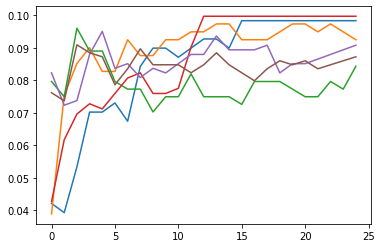

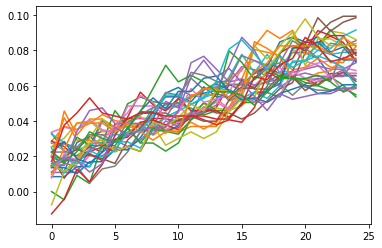

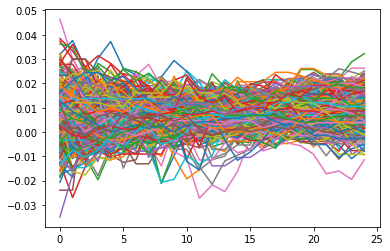

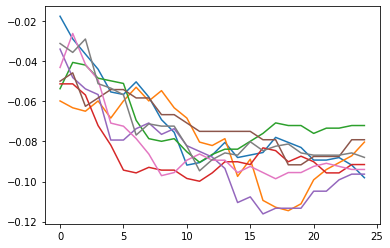

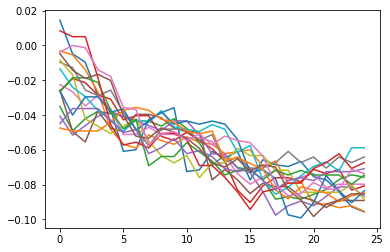

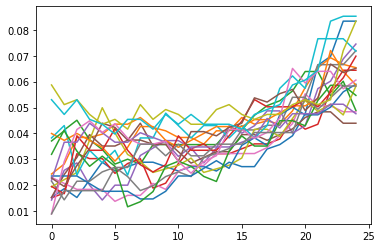

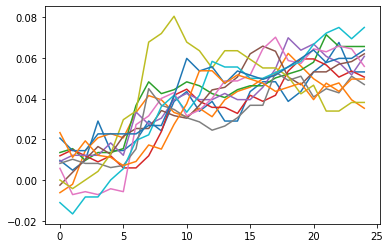

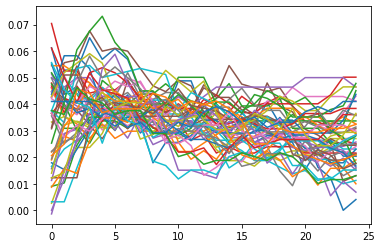

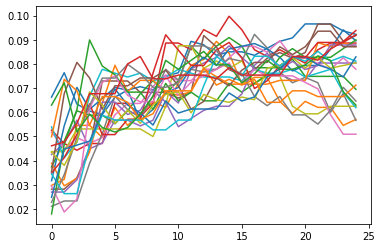

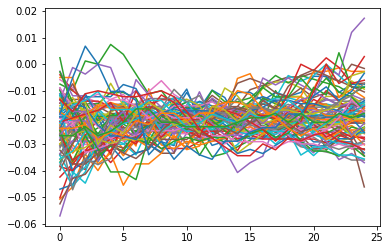

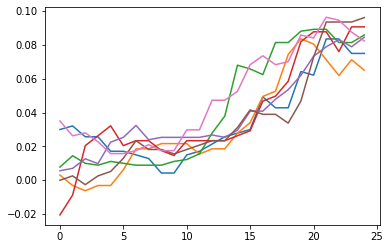

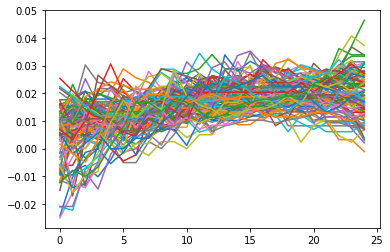

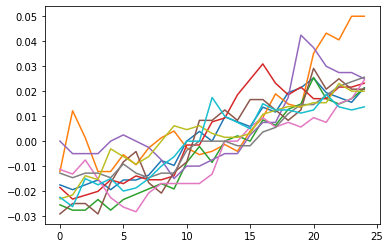

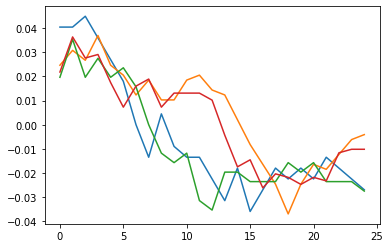

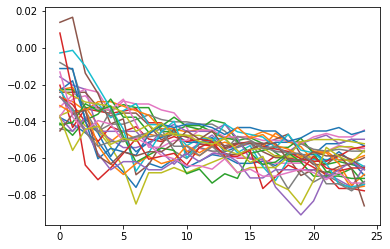

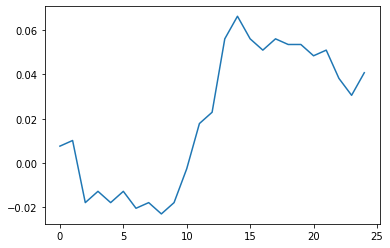

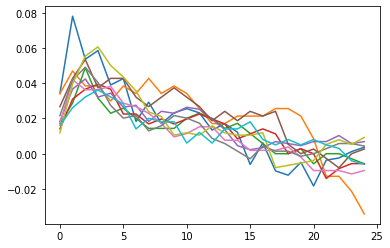

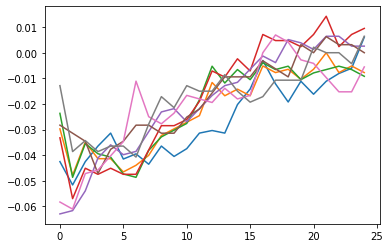

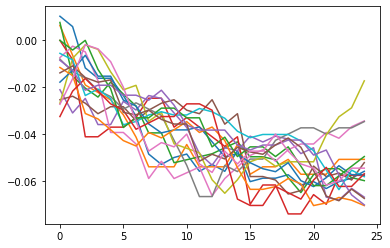

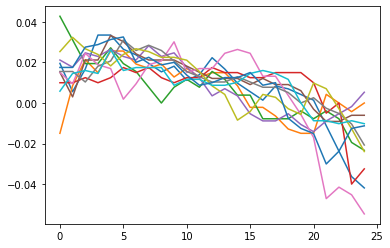

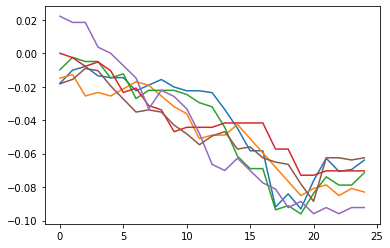

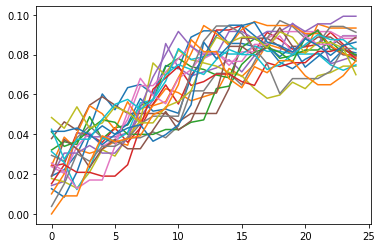

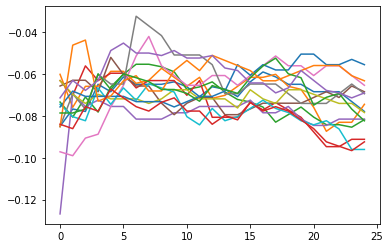

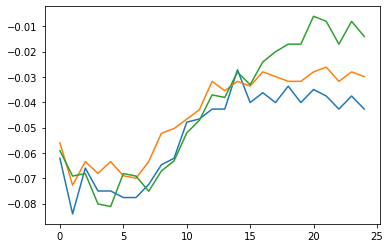

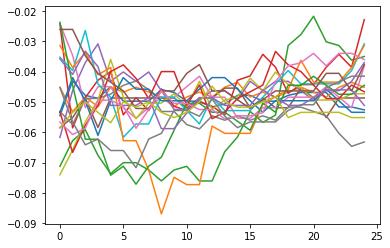

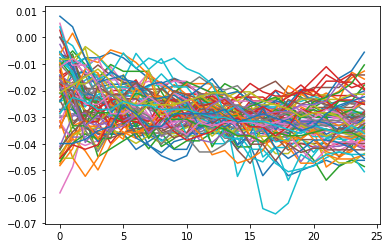

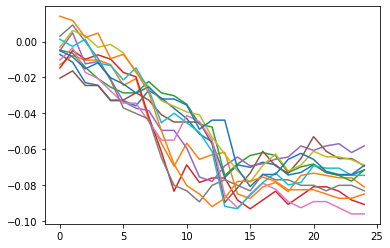

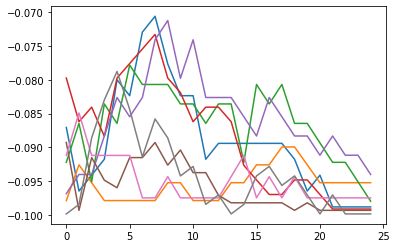

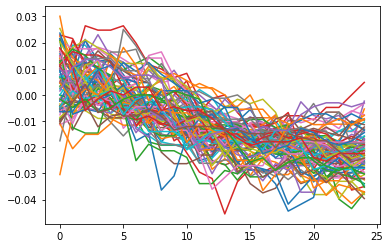

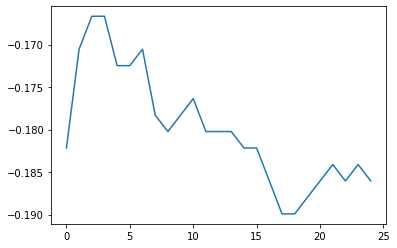

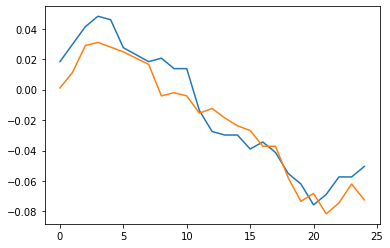

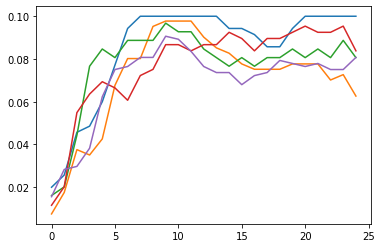

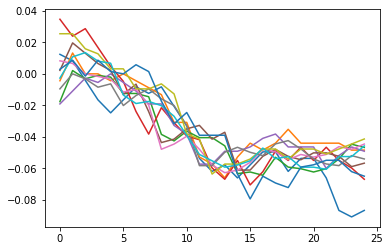

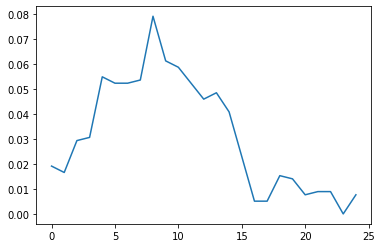

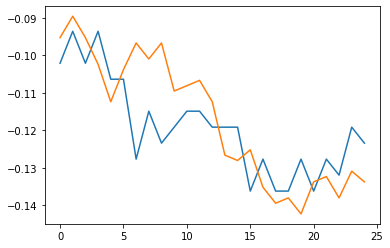

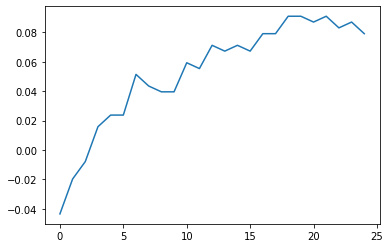

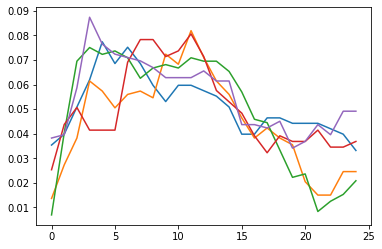

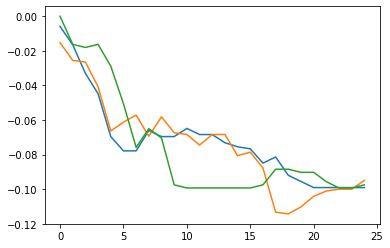

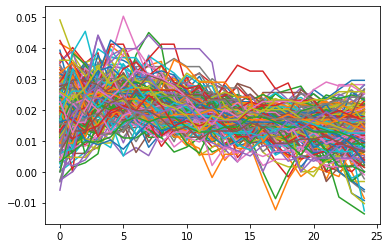

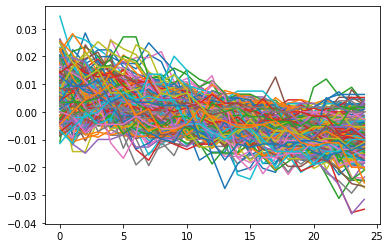

In [17]:
for n in range(NUM_CLUSTER):
    for i in range(len(X)):
    #     plt.subplot(10, 1, X_label[i]+1)
        if X_label[i] == n:
            plt.plot(X[i])
    plt.show()

In [18]:
def make_long_simple(y, cost):
    return y.max() - y[0] - cost
def make_short_simple(y, cost):
    return y[0] - y.min() - cost
def make_long_max_lost(y, cost):
    return y.min() - y[0] - cost
def make_short_max_lost(y, cost):
    return y[0] - y.max() - cost
def make_long(y, cost, exp_profit):
    if np.sum(y-y[0]-cost >= exp_profit):
        return exp_profit
    else:
        return y[-1] - y[0] - cost

def make_short(y, cost, exp_profit):
    if np.sum(y[0]-y-cost >= exp_profit):
        return exp_profit
    else:
        return -y[-1] + y[0] - cost

In [19]:
X_label

array([42, 42, 14, ...,  5, 19,  5], dtype=int64)

In [20]:
def make_table(X, X_label):
    X_mean = np.zeros((len(X_label), len(X[0])))
    for i in range(NUM_CLUSTER):
        X_mean[X_label[i]] = X[X_label==i].mean(axis=0)
    return X_mean
X_table = make_table(X, X_label)
pickle.dump(X_table, open("X_tabel.pk", "wb"))

In [21]:
len(X)

2492

In [22]:
Y.shape

(2492,)

In [23]:
profit_long_array = np.zeros(NUM_CLUSTER)
profit_short_array = np.zeros(NUM_CLUSTER)
lost_long_array = np.zeros(NUM_CLUSTER)
lost_short_array = np.zeros(NUM_CLUSTER)
num_long_array = np.zeros(NUM_CLUSTER).astype("int")
num_short_array = np.zeros(NUM_CLUSTER).astype("int")
for i in range(len(X)):
    profit_long_array[X_label[i]] += make_long_simple(Y[i], 0.002)
    profit_short_array[X_label[i]] += make_short_simple(Y[i], 0.002)
    lost_long_array[X_label[i]] += make_long_max_lost(Y[i], 0.002)
    lost_short_array[X_label[i]] += make_short_max_lost(Y[i], 0.002)
    num_long_array[X_label[i]] += 1
    num_short_array[X_label[i]] += 1
print(profit_long_array)
print(profit_short_array)
print(lost_long_array)
print(lost_short_array)
print(num_long_array)
print(num_short_array)

[ 2.23230197e-01  6.37386320e-01  2.45273114e+00  4.10815766e-01
  4.88466330e-01  1.41006984e+00  1.11175568e+00  1.38370445e+00
  4.83086126e-01  3.16996019e-01  2.01524070e-02  5.33539306e-01
  3.78925195e+00  4.05456139e-02  1.94632986e-01  3.10927883e-01
  1.63769187e-01  5.32102318e-01  1.97059363e-01  9.72199204e-01
  8.91091231e-02  9.58680308e-01  1.20257782e-01  1.76055176e-01
  2.53592528e-01  5.39796438e-02  9.77718813e-02  1.79311805e-01
  1.76203016e-01  2.53657546e-01  1.72904025e-02  2.42146294e-01
  2.72628749e-01  5.81544863e-02  2.86038900e-01  4.88997235e-01
  7.72129263e-02  3.90051302e-03  6.48711341e-01  3.81395349e-03
  5.87155963e-04  1.13370190e-01  2.06393572e-01  1.58571429e-02
  1.72887019e-02 -2.00000000e-03  2.78693670e-02 -4.19494585e-03
  1.72163079e+00  1.33294357e+00]
[ 1.46072274e-01  1.08435613e+00  2.55700214e+00  4.83325408e-01
  6.02773663e-01  2.03609394e+00  1.18335205e+00  1.00059325e+00
  2.98826043e-01  1.60072573e-01  4.18748600e-03  3.8612

In [24]:
pickle.dump(ac, open("ac_model2.pc", 'wb'))

In [ ]:
ac = pickle.load(open("ac_model2.pc", 'rb'))

In [25]:
profit_long_array = np.zeros(NUM_CLUSTER)
profit_short_array = np.zeros(NUM_CLUSTER)
lost_long_array = np.zeros(NUM_CLUSTER)
lost_short_array = np.zeros(NUM_CLUSTER)
num_long_array = np.zeros(NUM_CLUSTER).astype("int")
num_short_array = np.zeros(NUM_CLUSTER).astype("int")
for i in range(len(X)):
    profit_long_array[X_label[i]] += make_long_simple(Y[i], 0.002)
    profit_short_array[X_label[i]] += make_short_simple(Y[i], 0.002)
    lost_long_array[X_label[i]] += make_long_max_lost(Y[i], 0.002)
    lost_short_array[X_label[i]] += make_short_max_lost(Y[i], 0.002)
    num_long_array[X_label[i]] += 1
    num_short_array[X_label[i]] += 1
print('best avg long return',sorted(profit_long_array/num_long_array)[::-1][:10])
print('best avg short return' ,sorted(profit_short_array/num_short_array)[::-1][:10])
print('worst avg long return', sorted(lost_long_array/num_long_array)[::-1][:10])
print('worst avg short return', sorted(lost_short_array/num_short_array)[::-1][:10])
print(num_long_array)
print(num_short_array)

best avg long return [0.05397964376590329, 0.04401379411757489, 0.02305977689643507, 0.02267403804436608, 0.02241397561152876, 0.01938482876690288, 0.018763052014083795, 0.018175249959125346, 0.017171553622500793, 0.015857142857142743]
best avg short return [0.034251800743043424, 0.02962055335968381, 0.02637502666056138, 0.026061224489795948, 0.02323713883781488, 0.02218179757740376, 0.021749388550247484, 0.02013984035850782, 0.018893957948590168, 0.01831129862389901]
worst avg long return [-0.002686813186813186, -0.004544529262086502, -0.004697914333083215, -0.005875968992248097, -0.009317920828192274, -0.010155544669038046, -0.01177821658856084, -0.011945219575678718, -0.012003628630759652, -0.012323641992768362]
worst avg short return [-0.002, -0.0026016847172081916, -0.004293577981651376, -0.004487564128026673, -0.006881733745719778, -0.0073587345034953145, -0.007813953488372076, -0.009068201736796748, -0.00957387340403965, -0.009745446402042404]
[ 13  91 231  31  48 208 124 104  3

In [26]:
def find_cluster(X, X_table):
    prev_min = dtw_d(X, X_table[0])
    prev_min_arg = 0
    for i in range(1, NUM_CLUSTER):
        cur_min = dtw_d(X, X_table[i])
        if prev_min >= cur_min:
            prev_min = cur_min
            prev_min_arg = i
    return prev_min_arg

In [34]:
def find_cluster_L2(X, X_table):
    prev_min = dtw_d(X, X_table[0])
    prev_min_arg = 0
    for i in range(1, NUM_CLUSTER):
        cur_min = np.sum((X - X_table[i])**2)
        if prev_min >= cur_min:
            prev_min = cur_min
            prev_min_arg = i
    return prev_min_arg

In [35]:
find_cluster_L2(X_test[0], X_table)

3

In [36]:
profit_long_array = np.zeros(NUM_CLUSTER)
profit_short_array = np.zeros(NUM_CLUSTER)
lost_long_array = np.zeros(NUM_CLUSTER)
lost_short_array = np.zeros(NUM_CLUSTER)
num_long_array = np.zeros(NUM_CLUSTER).astype("int")
num_short_array = np.zeros(NUM_CLUSTER).astype("int")
for i in range(len(X)):
    profit_long_array[X_label[i]] += make_long(Y[i], 0.002, 0.025)
    profit_short_array[X_label[i]] += make_short(Y[i], 0.002, 0.025)
    num_long_array[X_label[i]] += 1
    num_short_array[X_label[i]] += 1
print('avg long return',sorted(profit_long_array/num_long_array)[::-1][:10])
print('avg short return' ,sorted(profit_short_array/num_short_array)[::-1][:10])
print(num_long_array)
print(num_short_array)
best_long_cluster = np.argsort(profit_long_array/num_long_array)[::-1]

avg long return [0.025, 0.010884164233192632, 0.009479591836734587, 0.008579842150095723, 0.006474893972878738, 0.004794741537202218, 0.004052567905904976, 0.003727355836497165, 0.003443650105017447, 0.0033587345034953135]
avg short return [0.025, 0.025, 0.025, 0.015115196417790603, 0.013953425253023562, 0.012927621222625498, 0.008661090565011114, 0.007945219575678718, 0.007601684717208177, 0.007067799095315568]
[ 13  91 231  31  48 208 124 104  33  20   6  35 426   8  17  20  12  53
  24  84   7 103  10   4  29   1  10   8  17  11   6  22  15   3  19  81
  12   8  86   1   2   5  11   1   2   1   5   3 189 232]
[ 13  91 231  31  48 208 124 104  33  20   6  35 426   8  17  20  12  53
  24  84   7 103  10   4  29   1  10   8  17  11   6  22  15   3  19  81
  12   8  86   1   2   5  11   1   2   1   5   3 189 232]


In [40]:
best_long_cluster

array([25, 27, 43, 29,  9, 41, 31,  8, 11, 10, 20, 23, 22, 15, 33,  0, 19,
        7, 42,  6, 21,  2,  3, 37, 12, 18,  5, 39, 34, 49, 38, 48,  4, 32,
        1, 36, 24, 35, 13, 44, 47, 28, 14, 16, 17, 30, 26, 46, 45, 40],
      dtype=int64)

In [42]:
def evaluate(X_test, Y_test, X_table):
    profit_long_array = np.zeros(NUM_CLUSTER)
    profit_short_array = np.zeros(NUM_CLUSTER)
    lost_long_array = np.zeros(NUM_CLUSTER)
    lost_short_array = np.zeros(NUM_CLUSTER)
    num_long_array = np.zeros(NUM_CLUSTER).astype("int")
    num_short_array = np.zeros(NUM_CLUSTER).astype("int")
    X_label = np.zeros(NUM_CLUSTER).astype("int")
    for i in range(len(X_test)):
        X_label = find_cluster(X_test[i], X_table)
        profit_long_array[X_label] += make_long(Y_test[i], 0.002, 0.025)
        profit_short_array[X_label] += make_short(Y_test[i], 0.002, 0.025)
        num_long_array[X_label] += 1
        num_short_array[X_label] += 1
        
        
    print('avg long return',sorted(profit_long_array/num_long_array)[::-1][:10])
    print('avg short return' ,sorted(profit_short_array/num_short_array)[::-1][:10])
    print(num_long_array)
    print(num_short_array)
    return np.array(sorted(profit_long_array/num_long_array)[::-1]), np.array(sorted(profit_short_array/num_short_array)[::-1]), num_long_array 

        

In [43]:
profit_long_array, profit_short_array, num_long_array  = evaluate(X_test, Y_test, X_table)

avg long return [-0.0013052319837549853, nan, nan, nan, 0.007560281230736102, 0.0038056733290402957, -0.00660617487054539, -0.018218210481363416, nan, nan]
avg short return [0.015431345263174925, 0.001703115726712799, nan, nan, nan, -0.006181485413333844, -0.0078056733290402976, nan, nan, nan]
[  0   0  16  68   3   1   0   2   8   0   0   2  18 126  86   0  63  54
   0   9   0   0   0  14   0   0   0  14   0   2   0   0   0   0  14   0
   0   0  16   0   0   0  12   0  11   0   0  37 188   7]
[  0   0  16  68   3   1   0   2   8   0   0   2  18 126  86   0  63  54
   0   9   0   0   0  14   0   0   0  14   0   2   0   0   0   0  14   0
   0   0  16   0   0   0  12   0  11   0   0  37 188   7]


C:\Users\JingYou\anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
C:\Users\JingYou\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
C:\Users\JingYou\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


In [44]:
for i in range(len(best_long_cluster)):
    print(i, profit_long_array[best_long_cluster[i]], num_long_array[best_long_cluster[i]])

0 nan 0
1 nan 14
2 -0.007223322946222699 0
3 nan 2
4 nan 0
5 -0.005279765812283907 0
6 0.025 0
7 nan 8
8 nan 2
9 nan 0
10 nan 0
11 nan 14
12 nan 0
13 -0.0033215307085018454 0
14 0.013923566878980902 0
15 -0.0013052319837549853 0
16 nan 9
17 -0.018218210481363416 2
18 -0.006102347970504892 12
19 -0.00660617487054539 0
20 nan 0
21 nan 16
22 nan 68
23 -0.003459518658243715 0
24 nan 18
25 nan 0
26 0.0038056733290402957 1
27 -0.003751717817254501 0
28 0.0006404298143429162 14
29 nan 7
30 -0.003510853808496841 16
31 nan 188
32 0.007560281230736102 3
33 nan 0
34 nan 0
35 -0.0014683303494159828 0
36 nan 0
37 0.0002634007830463302 0
38 nan 126
39 -0.008739712137081917 11
40 -0.03149589721795417 37
41 nan 0
42 -0.0027368050864730255 86
43 nan 63
44 nan 54
45 nan 0
46 nan 0
47 -0.012987164602300432 0
48 -0.010779204822515298 0
49 -0.0047069148961739376 0


C:\Users\JingYou\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


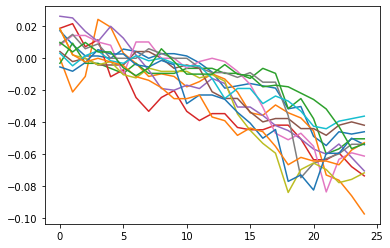

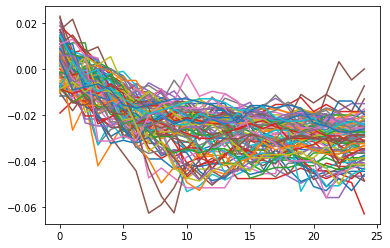

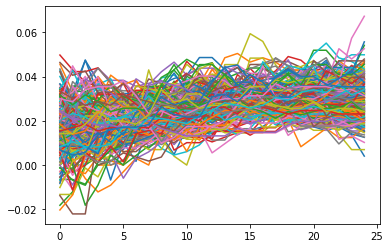

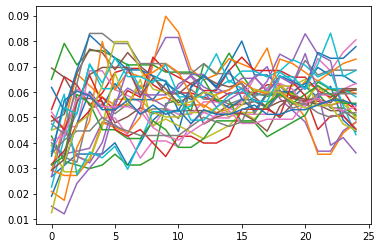

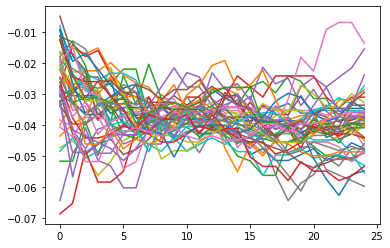

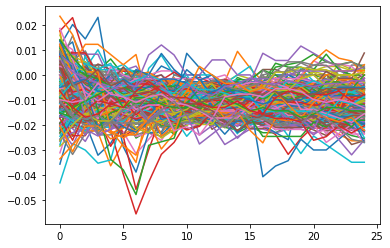

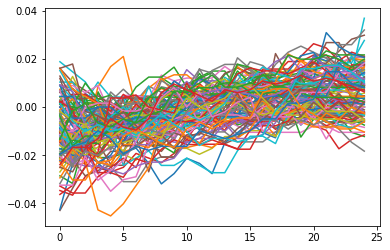

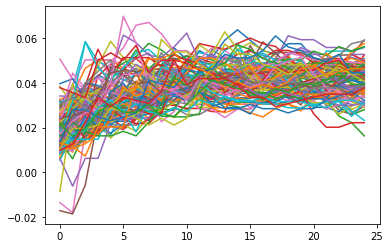

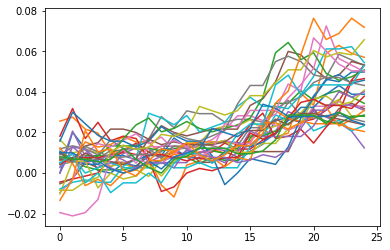

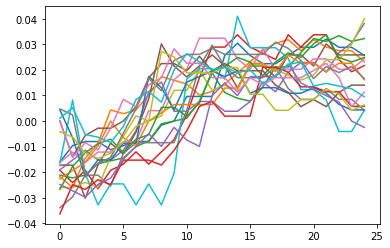

In [33]:
best_long_cluster = np.argsort(profit_long_array/num_long_array)[::-1]
for n in range(10):
    for i in range(len(X)):
    #     plt.subplot(10, 1, X_label[i]+1)
        if X_label[i] == n:
            plt.plot(X[i])
    plt.show()